In [28]:
import scenicplus 
import warnings
import sys
import os
warnings.simplefilter(action='ignore', category=FutureWarning) #this part of the code is created to suppress the warnings 
scenicplus.__version__

'1.0.1.dev4+ge4bdd9f'

In [29]:
_stderr = sys.stderr
null = open(os.devnull,'wb')

In [30]:
work_dir = '/Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data' #the work directory is indicated
tmp_dir = '/Users/diegoramirez/Desktop' #a tempral direcory is created to avoid save data o the memory after the work
if not os.path.exists(work_dir): 
    os.makedirs(work_dir)

In [8]:
#I coded this on my terminal inside the work dir 
!mkdir pbmc_tutorial/data
!cd pbmc_turorial/data
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
!wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz

mkdir: pbmc_tutorial/data: File exists


zsh:cd:1: no such file or directory: pbmc_turorial/data
--2023-09-29 18:12:37--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38844318 (37M) [binary/octet-stream]
Saving to: ‘pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5.1’

pbmc_granulocyte_so 100%[===================>]  37.04M  20.1MB/s    in 1.8s    

2023-09-29 18:12:40 (20.1 MB/s) - ‘pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5.1’ saved [38844318/38844318]

--2023-09-29 18:12:40--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_granulocyte_sorted_3k/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173
Connecting to cf.10x

In [31]:
work_dir =  '/Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code'

In [32]:
#First we preprocess the scRNA-seq side of the multiome datasets. Most importantly we will use this side of the data to annotate celltypes.
#We will use scanpy 
import scanpy as sc
#Set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')


##make a directory for to store the processed scRNA-seq data.
#In this case we use the path.exists method from os to evaluate the existence of the concatenation work_dir path with the scRNA path i.e they are continuous along the same path
if not os.path.exists(os.path.join(work_dir, 'scRNA')): #method in Python is used to check whether the specified path exists or not. 
                                                        #This method can be also used to check whether the given path refers to an open file descriptor or not. 
                                                        #RETURNS F OR T
    os.makedirs(os.path.join(work_dir, 'scRNA')) #Os.path.join is a method to concatenate various path components with an / separator, it ignores non-absolute paths and files on the concatenation

In [33]:
#We read the data with the scanpy function
adata = sc.read_10x_h5(os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_filtered_feature_bc_matrix.h5')) #This line can be edited changing the sc.read_10x_h5 to sc.read_10x_h5ad
adata.var_names_make_unique()
adata

/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2711 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [34]:
sc.pp.filter_cells(adata, min_genes=200) #We filter the cells by min num of genes
sc.pp.filter_genes(adata, min_cells=3) #We filter genes by min num of cells expressing that gene

In [35]:
#I had to install scrublet by bioconda (conda install -c bioconda sceublet)
import scrublet as scr
#In this case we used .external because we need to use another package with scrublet (I think only some package can do this)
sc.external.pp.scrublet(adata)

/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.24
Detected doublet rate = 2.7%
Estimated detectable doublet fraction = 53.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.0%


In [36]:
adata = adata[adata.obs['predicted_doublet'] == False] #do the actual filtering
adata

View of AnnData object with n_obs × n_vars = 2627 × 21255
    obs: 'n_genes', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'scrublet'

In [37]:
#We create filters focused on mithocondrial counts and total counts
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True) #This line indicate some parameters for the 
                                                                                                #mithocondrial genes 
#https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.calculate_qc_metrics.html

/var/folders/j4/rlfkr11d58s6dng7dnf1bv4m0000gn/T/ipykernel_3575/1550908096.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


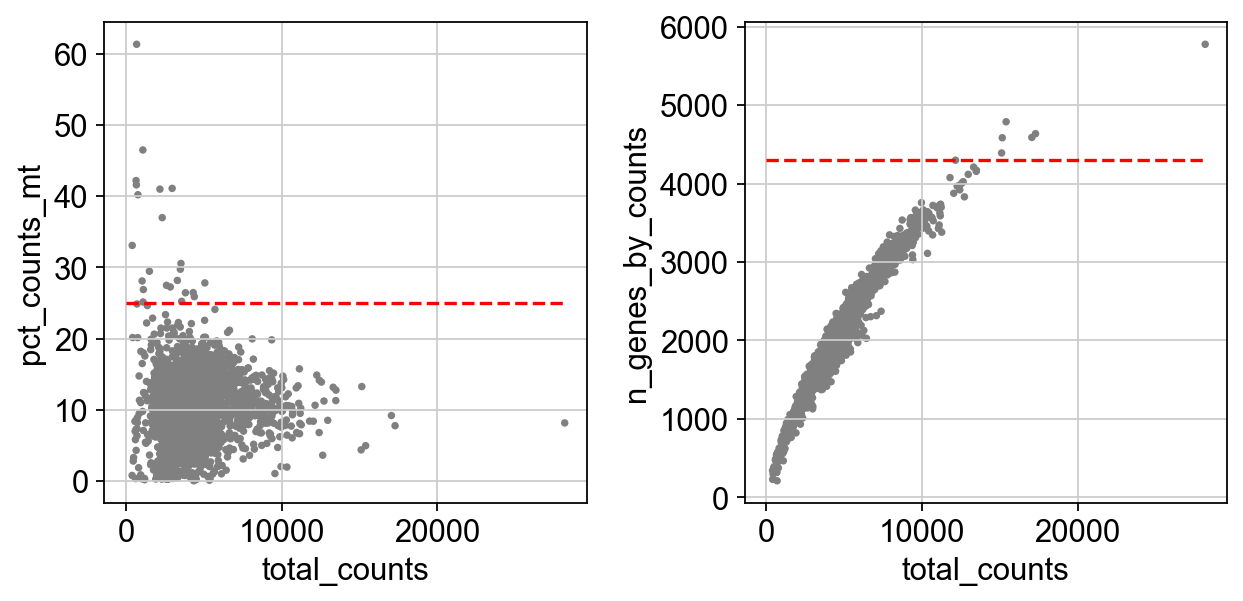

In [39]:
import matplotlib.pyplot as plt
#from tkinter import *
##I had to use pip3 install tk
#In one instance i needed to install again with pip3 scanpy and then run all from that part until this to create the plots 
#Por alguna razon tengo que correr todo desde el inicio hasta aca haciendo antes el pip 
import tkinter
mito_filter = 25
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
#We created this code lines to visualize both plots on the same print, the axis x an y came from the adata.obs, so this came from cell (barcodes) statistics
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax = axs[0], show=False) #A plot with the total counts vs the percetantage of the mt counts 
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax = axs[1], show = False) #Another plot but with the number of genes by counts
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed') #The max is the max number of counts observed
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

We can observe some dying cells indicated by the high percentage of mithocondrial genes expressed (above 25% in this threshold) indicated by the red line, in the right plot we can observe an increasing number of genes wuth at least one read showed as the total counts increase, this ov¿bservation makes sense, the reed line indicates a threshold for 4300 expressed genes 

In [40]:
adata = adata[adata.obs.n_genes_by_counts < n_counts_filter, :] #We only take genes below 4300 reads   
adata = adata[adata.obs.pct_counts_mt < mito_filter, :] #We only conserve cells with a pct of mt counts below 25%
adata #As we can observe we filtered out 29 cells (barcodes)

View of AnnData object with n_obs × n_vars = 2598 × 21255
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'

In [41]:
###WE WILL NORMALIZE THE DATA AT THIS POINT###.

adata.raw = adata
#The .pp is to indicate the preprocessing set of funcion from scanpy 
sc.pp.normalize_total(adata, target_sum=1e4) #The aim of this line os to normalize the counts for each cell by the total number of counts, so that every cell has the same count after.
#if choosing target_sum=1e6 is conts per million normalization, so in this case is count per 10 thousand                                              
sc.pp.log1p(adata) #This line logarithmize the matrix
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) #This line annotate the highly variable genes [Satija15][Zheng17][Staurt19]
adata = adata[:, adata.var.highly_variable] #This line filter the anndata object only by the highly variable genes, expects logarithmized data, except when flavor='seuratv3' in which count data is expected
sc.pp.scale(adata, max_value=10) #This line scale the data to unit variance and zero mean ; the max_value clip(truncate) to this value after scaling (i think take 10 counts as max)


/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [42]:
###CELL TYPE ANNOTATION.
#In this case a pre-annotated dataset as refresence was used (the scanpy tutorial dataset) to transfer labels to unnanotated dataset using ingest.
#This is an important step of the preprocessing part because these annotations will be used in pycisTopic to generate pseudobulk ATAC profiles  and call peaks.

adata_ref = sc.datasets.pbmc3k_processed() #use the preprocessed data from the Scanpy tutorial as reference that is already in the scanpy package
var_names = adata_ref.var_names.intersection(adata.var_names) #use genes which are present in both assays using the intersection function inside the variable names from reference
adata_ref = adata_ref[:, var_names] #We select the names filtered on the previous step in the adata_ref
adata = adata[:, var_names] #We do the same on the actual dataset to analyze 
sc.pp.pca(adata_ref) #calculate PCA embedding on the reference dataset 
sc.pp.neighbors(adata_ref) #calculate neighborhood graph on the reference dataset
sc.tl.umap(adata_ref) #calculate umap embedding on the reference dataset
sc.tl.ingest(adata, adata_ref, obs='louvain') #run label transfer, ingest Map labels and embeddings from reference data to new data, 
#obs cooresponds to labels key's in ref which need to be mapped, in this case louvain corresponds to the clustering performed on the reference dataset
adata.obs.rename({'louvain': 'ingest_celltype_label'}, inplace = True, axis = 1) #This line is created to change the name of the transfered names from louvain to ingest_celltype_label

/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


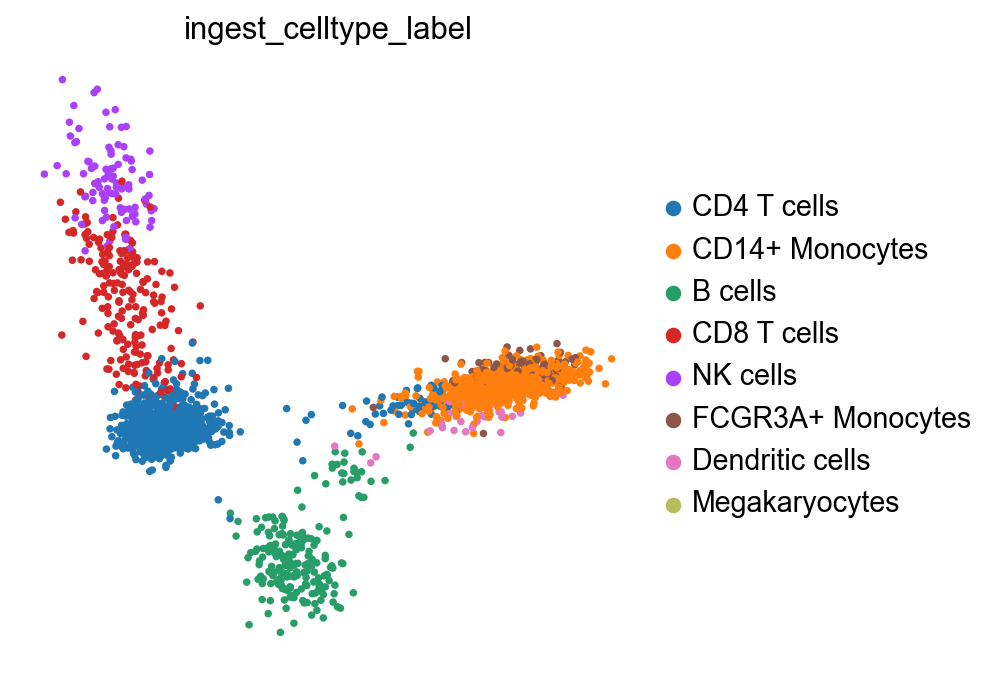

/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8942 (\N{VERTICAL ELLIPSIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


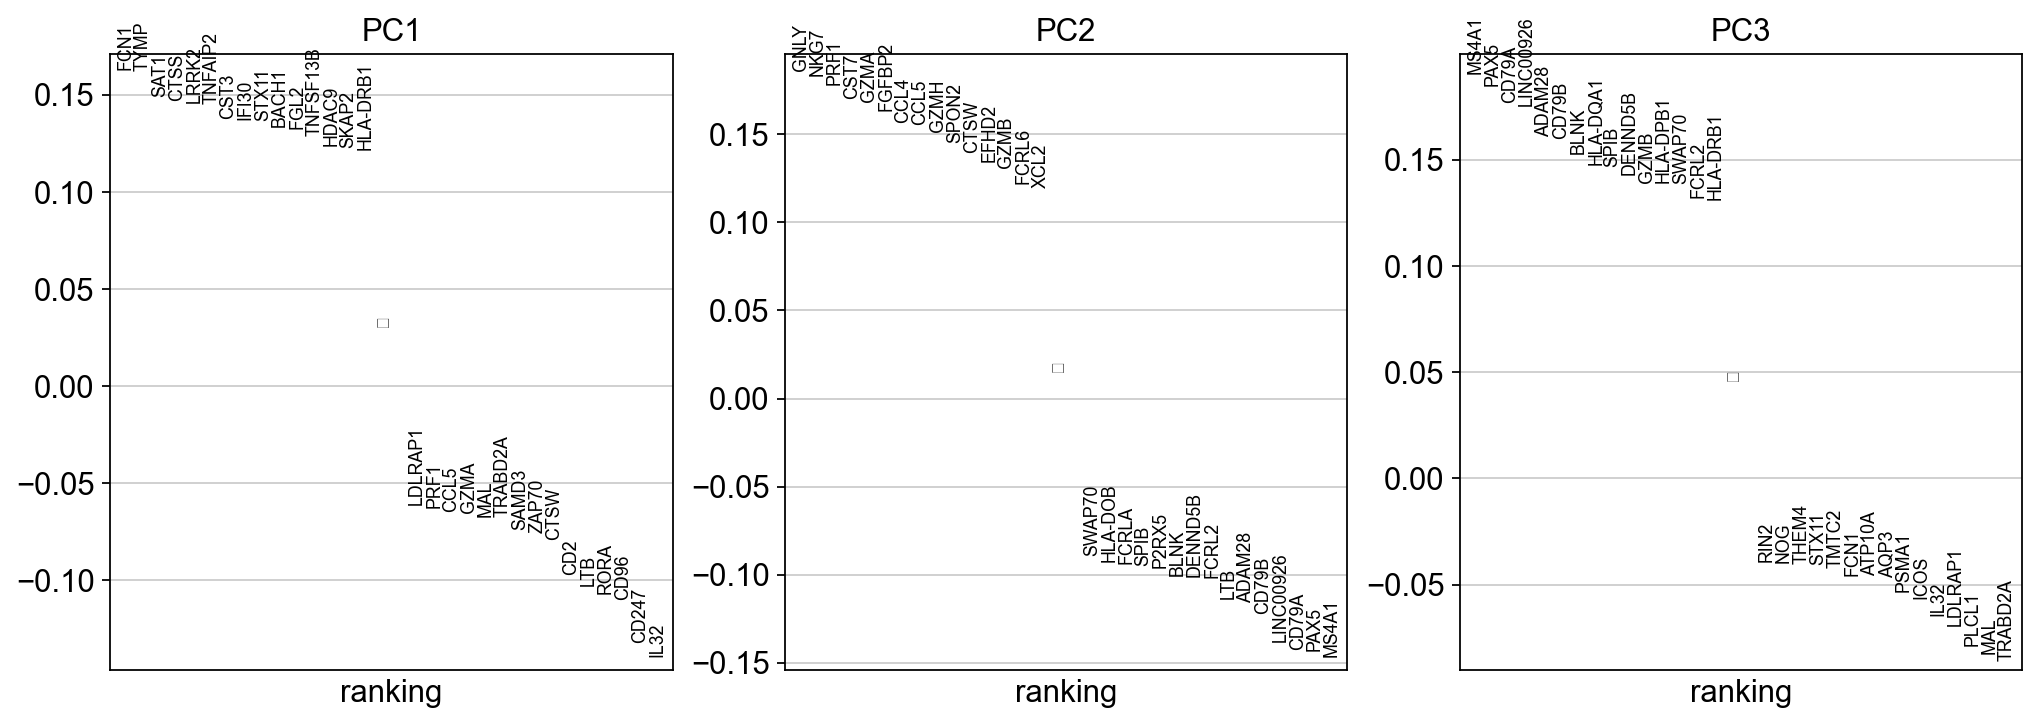

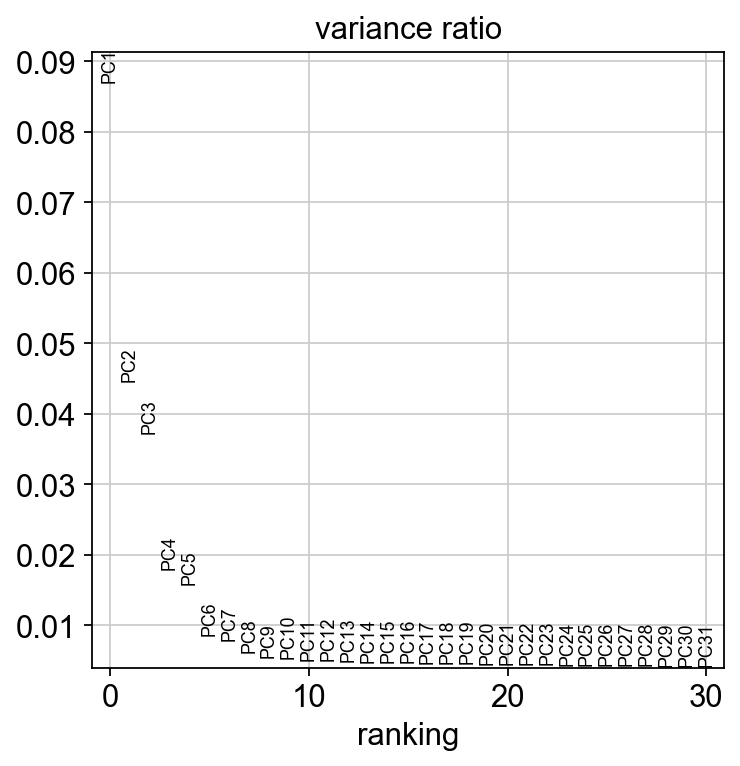

In [43]:
sc.tl.pca(adata, svd_solver='arpack') #tl came from tools of the scanpy package, this line computes pca coordinates, loadings and variance decomposition. Uses scikit-learn implementation  
#As this adata object is not array-like, the result will be added as extra fields: .obsm (PCA representation), .varm (The PCs containing the loadings), .uns (Ratio of explained variance)
sc.pl.pca_overview(adata, color="ingest_celltype_label") #This line plots an overview of the PCA variance captures and the loadings of the top 3 components

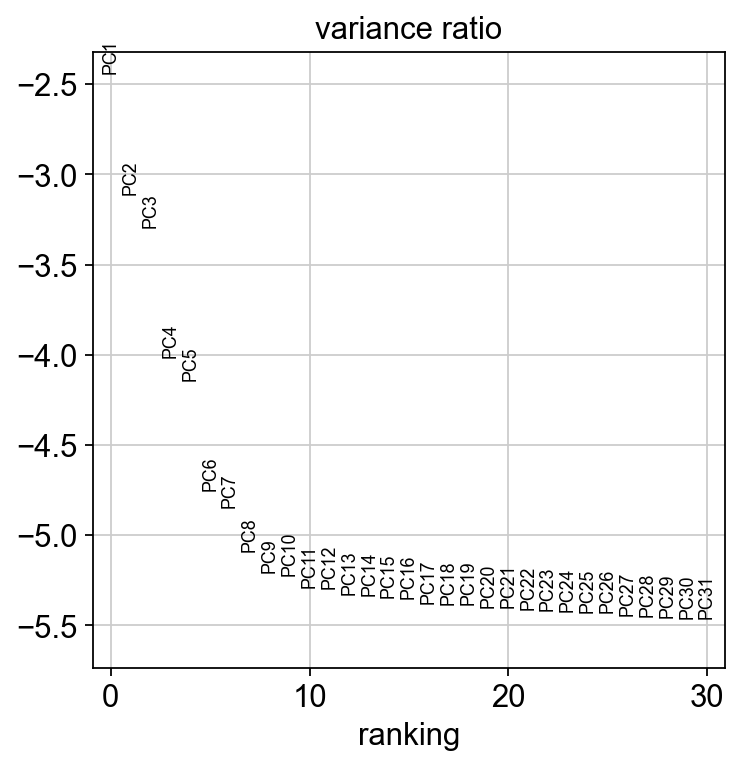

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)#This line plots the captured variance but using the log=TRUE argument weobserve the significance fro each component better distribuited

/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


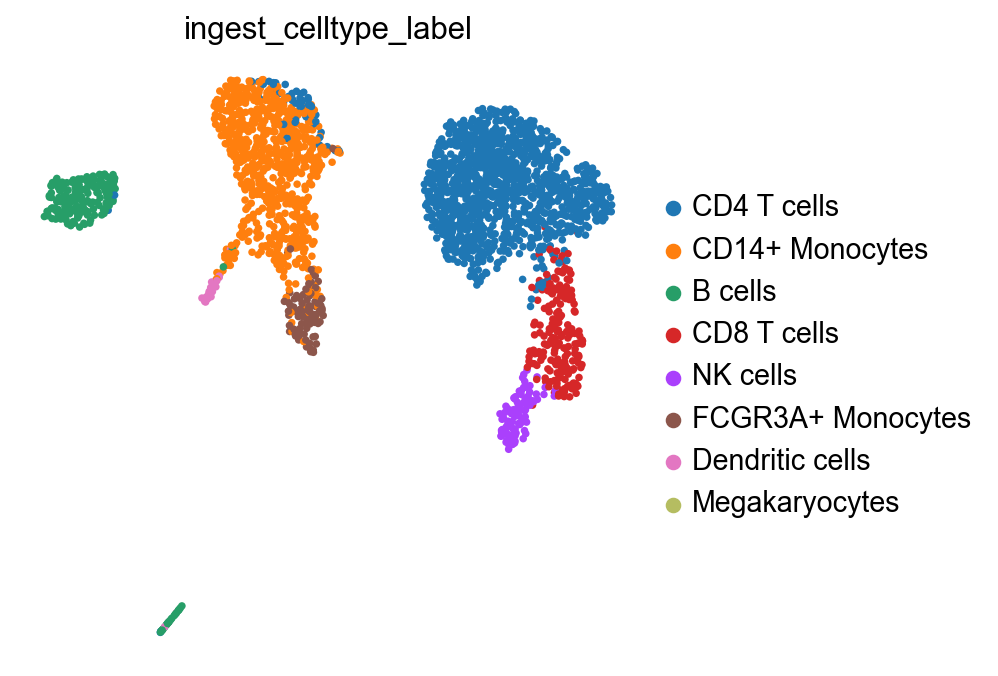

In [44]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10) #This line computes a neighborhood graph of observations. The neighbor search efficiency of this heavily relies on UMAP 
sc.tl.umap(adata) #This line embed the neighborhood graph using UMAP
sc.pl.umap(adata, color = 'ingest_celltype_label') #This line plot the umap using celltype lables from ingest as color code

/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


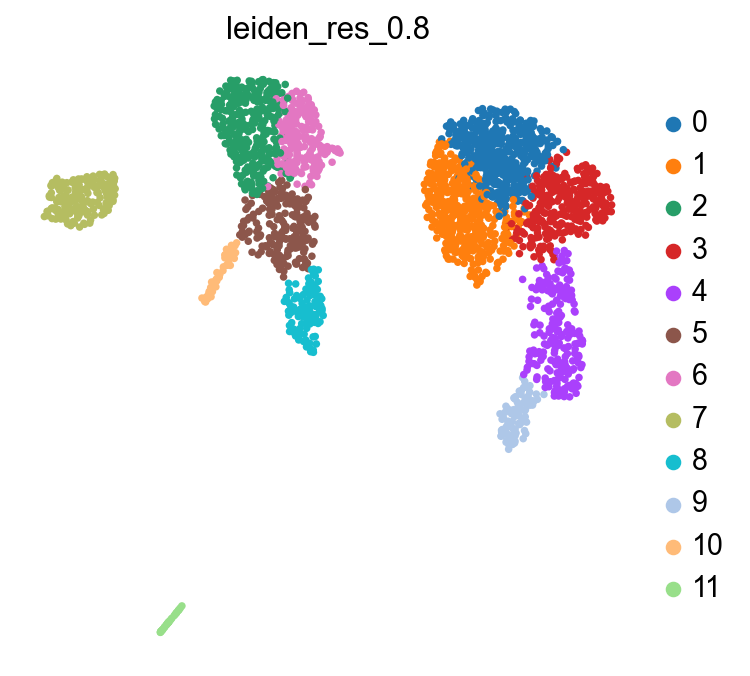

In [47]:
##We can clean the annotation a bit by running a clustering and assigning clusters to cell types based on maximum overlap.
#I had to install leidenagl package with pip3 install and conda install
#https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.leiden.html
import leidenalg
sc.tl.leiden(adata, resolution = 0.8, key_added = 'leiden_res_0.8') #This line clusters the cells into subgroups using leiden [Traag18], an improved version  of louvain.
#resolution indicates the coarseness of the clustering, higher values lead to more clusters, key_added add the label names under the cluster the cluster will be added.
sc.pl.umap(adata, color = 'leiden_res_0.8') #this line plots a umap but in this case using the leiden clustering instead of knn

In [50]:
tmp_df = adata.obs.groupby(['leiden_res_0.8', 'ingest_celltype_label']).size().unstack(fill_value=0) #groupby agrupa los datos según los valores unicos de leiden e ingest, size calcula
#el numero de observaciones en lo que se agrupara, unstack se hace en el resultado y toma lo agrupado convirtiendo leiden en columnas e ingest en indices de la fila, si algun valor no Existe, se hace 0
tmp_df = (tmp_df / tmp_df.sum(0)).fillna(0) #This line is created to calculate  proportion of each entry against the whole column, fillna llena NaN con 0
leiden_to_annotation = tmp_df.idxmax(1).to_dict() #This search for the maximun value in each element from the column and the function .to_dict convert the indexes into a dictionary.
#The keys are the ingest labels (column indexes) and the values are the names in the column with the maximun values in that rows 
leiden_to_annotation

{'0': 'CD4 T cells',
 '1': 'CD4 T cells',
 '2': 'CD14+ Monocytes',
 '3': 'CD4 T cells',
 '4': 'CD8 T cells',
 '5': 'CD14+ Monocytes',
 '6': 'CD14+ Monocytes',
 '7': 'B cells',
 '8': 'FCGR3A+ Monocytes',
 '9': 'NK cells',
 '10': 'Dendritic cells',
 '11': 'B cells'}

Adata.var: contins information about the genes like counts for each gene, feature type, Genes IDs, std, ectc.
Adata.obs: contains information about each cell and statisttis calculated like mithocondrial read proportion, total counts, cell type 

We can note that we have two clusters of B cells. Let's call these B cells 1 and B cells 2

In [51]:
leiden_to_annotation['7'] = 'B cells 1' #This line changes the name of the cluster
leiden_to_annotation['11'] = 'B cells 2' #This line changes the name of the cluster 
leiden_to_annotation = {cluster: leiden_to_annotation[cluster].replace(' ', '_') for cluster in leiden_to_annotation.keys()} #This line created substituted each space for a '_'  
leiden_to_annotation

{'0': 'CD4_T_cells',
 '1': 'CD4_T_cells',
 '2': 'CD14+_Monocytes',
 '3': 'CD4_T_cells',
 '4': 'CD8_T_cells',
 '5': 'CD14+_Monocytes',
 '6': 'CD14+_Monocytes',
 '7': 'B_cells_1',
 '8': 'FCGR3A+_Monocytes',
 '9': 'NK_cells',
 '10': 'Dendritic_cells',
 '11': 'B_cells_2'}

In [52]:
adata.obs['celltype'] = [leiden_to_annotation[cluster_id] for cluster_id in adata.obs['leiden_res_0.8']] #This line creates a new section in the adata.obs searching for common labels in
#our data to analyse and the annotation dataset
del(leiden_to_annotation) #This line deletes the dictionary with the celltypes labels
del(tmp_df) #This line deleytes the datafrae with the labels 

/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


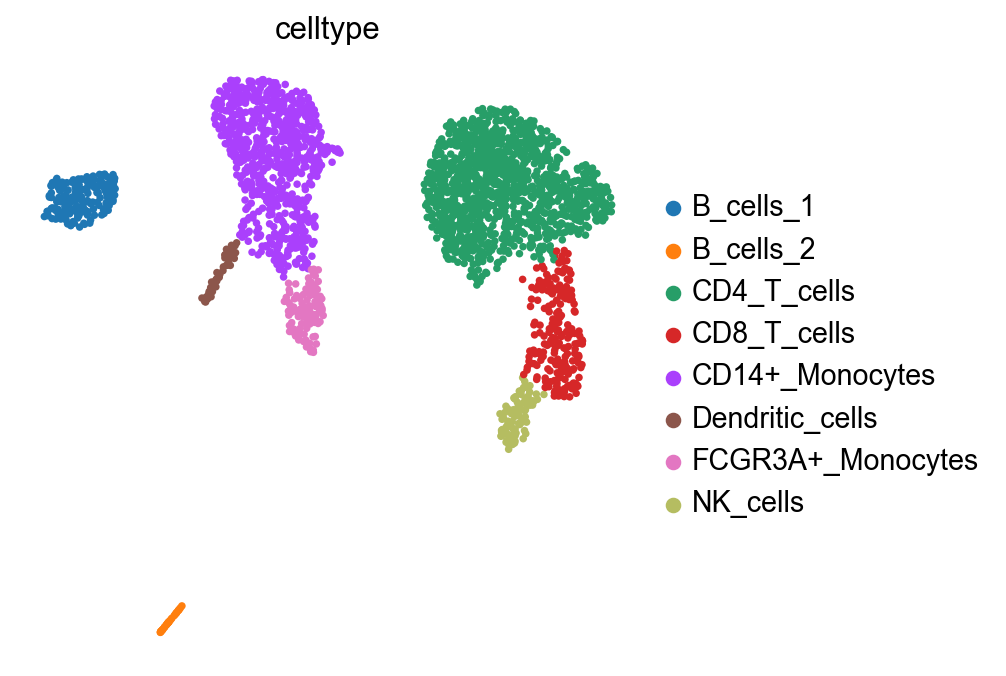

In [53]:
sc.pl.umap(adata, color = 'celltype') #This line plots a umap but using the leiden clustering instead louvains but with the celltype labels

In [54]:
adata.write(os.path.join(work_dir, 'scRNA/adata.h5ad'), compression='gzip') #This line save results

At this point we already preprocessed the data using the scanpy tutorial, we will proceed with the downstream analysis as if the data were separate multiome assays.

scTACA-Seq preprocesing:
The scATAC-seq preprocessing steps are almost identical to preprocessing multiome data. The big difference is that in this case we will not use the cell type annotation from the scRNA-seq side. We will use the demuxlet results instead.

In [61]:
#path to fragment files
#In this case we need to define a path for every sample of ATAC-seq (every tsv.gz framgent file)
import os 
work_dir = '/Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code'
#To install pycisTopic i had to clone the github repository 
import pycisTopic
import scanpy as sc
%matplotlib inline
_stderr = sys.stderr
null = open(os.devnull,'wb')
#This code create a scATAC directory to save the results from the scATAc-seq analysis if it does not exists 
if not os.path.exists(os.path.join(work_dir, 'scATAC')): 
    os.makedirs(os.path.join(work_dir, 'scATAC'))
    tmp_dir = '/Users/diegoramirez/Desktop'


In [69]:
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'data/3k_fragments/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')} #This line can be edited to indicate more fragment files

#fragments_dict_multiplesamples = {
#    'p1': os.path.join(work_dir, 'route/to/fragments/file/fragments_1.tsv.gz'),
#    'p2'= os.path.join(work_dir, 'route/to/fragments/file/fragments_2.tsv.gz'),
#    'p2'= os.path.join(work_dir, 'route/to/fragments/file/fragments_3.tsv.gz')}

#In the case of unmatched samples we have to indicate also the path to the demuxlet results, so we have to integrate demixlet on the pipeline if we want to use this

In [67]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
adata.obs

,n_genes,doublet_score,predicted_doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,ingest_celltype_label,leiden_res_0.8,celltype
AAACAGCCAAATATCC-1,2272,0.009280,False,2271,4746.0,369.0,7.774969,NK cells,9,NK_cells
AAACAGCCAGGAACTG-1,3254,0.021077,False,3253,7760.0,693.0,8.930412,CD14+ Monocytes,5,CD14+_Monocytes
AAACAGCCAGGCTTCG-1,1798,0.042017,False,1793,3661.0,409.0,11.171811,CD14+ Monocytes,2,CD14+_Monocytes
AAACCAACACCTGCTC-1,1145,0.016376,False,1142,2159.0,271.0,12.552108,B cells,7,B_cells_1
AAACCAACAGATTCAT-1,1495,0.016376,False,1494,2909.0,293.0,10.072189,NK cells,4,CD8_T_cells
...,...,...,...,...,...,...,...,...,...,...
TTTGTGGCATCCGTAA-1,1346,0.008696,False,1343,2560.0,432.0,16.875000,B cells,7,B_cells_1
TTTGTGGCATTAGCCA-1,972,0.021077,False,969,1746.0,191.0,10.939290,CD4 T cells,1,CD4_T_cells
TTTGTGGCATTGCGAC-1,2330,0.008696,False,2330,4772.0,316.0,6.621961,NK cells,9,NK_cells
TTTGTGTTCCGCCTAT-1,1057,0.054726,False,1056,1913.0,252.0,13.173027,CD4 T cells,1,CD4_T_cells


In [86]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
adata.obs['batch'] = '10x_pbmc'
cell_data = adata.obs
cell_data['sample_id'] = cell_data['batch'] #Here I had a problem because the sample_id is necessary for the pseudobulk function and this works per fragments file, the code search for 
#the name of each fragment file in this sample_id new column, so the names have to match with the batch name for each cell
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [87]:
cell_data['sample_id']

AAACAGCCAAATATCC-1    10x_pbmc
AAACAGCCAGGAACTG-1    10x_pbmc
AAACAGCCAGGCTTCG-1    10x_pbmc
AAACCAACACCTGCTC-1    10x_pbmc
AAACCAACAGATTCAT-1    10x_pbmc
                        ...   
TTTGTGGCATCCGTAA-1    10x_pbmc
TTTGTGGCATTAGCCA-1    10x_pbmc
TTTGTGGCATTGCGAC-1    10x_pbmc
TTTGTGTTCCGCCTAT-1    10x_pbmc
TTTGTGTTCCGTGACA-1    10x_pbmc
Name: sample_id, Length: 2598, dtype: object

In [88]:
# Get chromosome sizes (for hg38 here)
import pyranges as pr
import requests
import pandas as pd
target_url='http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes' 
chromsizes=pd.read_csv(target_url, sep='\t', header=None) 
chromsizes.columns=['Chromosome', 'End'] 
chromsizes['Start']=[0]*chromsizes.shape[0]
chromsizes=chromsizes.loc[:,['Chromosome', 'Start', 'End']]
# Exceptionally in this case, to agree with CellRangerARC annotations
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].replace('v', '.') for x in range(len(chromsizes['Chromosome']))]
chromsizes['Chromosome'] = [chromsizes['Chromosome'][x].split('_')[1] if len(chromsizes['Chromosome'][x].split('_')) > 1 else chromsizes['Chromosome'][x] for x in range(len(chromsizes['Chromosome']))]
chromsizes=pr.PyRanges(chromsizes)

In [89]:
work_dir

'/Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code'

In [90]:
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(input_data = cell_data,
                 variable = 'celltype',                                                                     # variable by which to generate pseubulk profiles, in this case we want pseudobulks per celltype
                 sample_id_col = 'sample_id',
                 chromsizes = chromsizes,
                 bed_path = os.path.join(work_dir, 'scATAC_3k/consensus_peak_calling/pseudobulk_bed_files/'),  # specify where pseudobulk_bed_files should be stored
                 bigwig_path = os.path.join(work_dir, 'scATAC_3k/consensus_peak_calling/pseudobulk_bw_files/'),# specify where pseudobulk_bw_files should be stored
                 path_to_fragments = fragments_dict,                                                        # location of fragment fiels
                 n_cpu = 8,                                                                                 # specify the number of cores to use, we use ray for multi processing
                 normalize_bigwig = True,
                 remove_duplicates = True,
                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'),
                 split_pattern = '-')

2024-03-18 09:45:40,591 cisTopic     INFO     Reading fragments from /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/3k_fragments/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz


2024-03-18 09:46:19,668	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


OutOfDiskError: Local disk is full
The object cannot be created because the local object store is full and the local disk's utilization is over capacity (95% by default).Tip: Use `df` on this node to check disk usage and `ray memory` to check object store memory usage.

(export_pseudobulk_ray pid=24323) 2024-03-18 09:46:23,198 cisTopic     INFO     Creating pseudobulk for B_cells_1


2024-03-18 09:46:28,854	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::export_pseudobulk_ray() (pid=24323, ip=127.0.0.1)
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py", line 346, in export_pseudobulk_ray
    export_pseudobulk_one_sample(
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py", line 285, in export_pseudobulk_one_sample
    group_pr.to_bigwig(
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pyranges/pyranges_main.py", line 5506, in to_bigwig
    result = _to_bigwig(self, path, chromosome_sizes, rpm, divide, value_col, dryrun)
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pyranges/out.py", line 212, in _to_bigwig
    unique_chromosomes = gr.chromosomes
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/si

(export_pseudobulk_ray pid=24323) 2024-03-18 09:46:28,931 cisTopic     INFO     Creating pseudobulk for B_cells_2


(raylet) [2024-03-18 09:46:29,737 E 24314 1191675] (raylet) file_system_monitor.cc:111: /Users/diegoramirez/Desktop/ray_spill/session_2024-03-18_09-46-16_302320_3575 is over 95% full, available space: 6054912000; capacity: 494384795648. Object creation will fail if spilling is required.
2024-03-18 09:46:31,106	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::export_pseudobulk_ray() (pid=24323, ip=127.0.0.1)
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py", line 346, in export_pseudobulk_ray
    export_pseudobulk_one_sample(
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py", line 285, in export_pseudobulk_one_sample
    group_pr.to_bigwig(
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pyranges/pyranges_main.py", line 5506, in to_bigwig
    result = _to_bigwig(self, pa

In [12]:
import pickle
pickle.dump(bed_paths,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'wb'))
pickle.dump(bw_paths,
           open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'wb'))

In [ ]:
import pickle
# I had to run pip install pyrle
bed_paths = pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bed_paths.pkl'), 'rb'))
bw_paths =  pickle.load(open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/pseudobulk_bed_files/bw_paths.pkl'), 'rb'))
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path='macs2'
# Run peak calling
narrow_peaks_dict = peak_calling(macs_path,
                                 bed_paths,
                                 os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/'),
                                 genome_size='hs',
                                 n_cpu=8,
                                 input_format='BEDPE',
                                 shift=73,
                                 ext_size=146,
                                 keep_dup = 'all',
                                 q_value = 0.05,
                                 _temp_dir = os.path.join(tmp_dir, 'ray_spill'))

2024-02-25 21:07:02,747	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(macs_call_peak_ray pid=6226) 2024-02-25 21:07:05,419 cisTopic     INFO     Calling peaks for B_cells with macs2 callpeak --treatment /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/pseudobulk_bed_files/B_cells.bed.gz --name B_cells  --outdir /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=6230) 2024-02-25 21:07:05,403 cisTopic     INFO     Calling peaks for CD8_T_cells with macs2 callpeak --treatment /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/pseudobulk_bed_files/CD8_T_cells.bed.gz --name CD8_T_cells  --outdir /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize

RayTaskError(RuntimeError): [36mray::macs_call_peak_ray()[39m (pid=6229, ip=127.0.0.1)
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/subprocess.py", line 415, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/subprocess.py", line 516, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command 'macs2 callpeak --treatment /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/pseudobulk_bed_files/B_cells_2.bed.gz --name B_cells_2  --outdir /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda' returned non-zero exit status 1.

During handling of the above exception, another exception occurred:

[36mray::macs_call_peak_ray()[39m (pid=6229, ip=127.0.0.1)
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py", line 585, in macs_call_peak_ray
    MACS_peak_calling = MACSCallPeak(
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py", line 658, in __init__
    self.call_peak()
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/pycisTopic/pseudobulk_peak_calling.py", line 699, in call_peak
    raise RuntimeError(
RuntimeError: command 'macs2 callpeak --treatment /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/pseudobulk_bed_files/B_cells_2.bed.gz --name B_cells_2  --outdir /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda' return with error (code 1): b'INFO  @ Sun, 25 Feb 2024 21:07:05: \n# Command line: callpeak --treatment /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/pseudobulk_bed_files/B_cells_2.bed.gz --name B_cells_2 --outdir /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda\n# ARGUMENTS LIST:\n# name = B_cells_2\n# format = BEDPE\n# ChIP-seq file = [\'/Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/pseudobulk_bed_files/B_cells_2.bed.gz\']\n# control file = None\n# effective genome size = 2.70e+09\n# band width = 300\n# model fold = [5, 50]\n# qvalue cutoff = 5.00e-02\n# The maximum gap between significant sites is assigned as the read length/tag size.\n# The minimum length of peaks is assigned as the predicted fragment length "d".\n# Larger dataset will be scaled towards smaller dataset.\n# Range for calculating regional lambda is: 10000 bps\n# Broad region calling is off\n# Paired-End mode is on\n# Searching for subpeak summits is on\n \nINFO  @ Sun, 25 Feb 2024 21:07:05: #1 read fragment files... \nINFO  @ Sun, 25 Feb 2024 21:07:05: #1 read treatment fragments... \nTraceback (most recent call last):\n  File "/Users/diegoramirez/anaconda3/envs/scenicplus/bin/macs2", line 653, in <module>\n    main()\n  File "/Users/diegoramirez/anaconda3/envs/scenicplus/bin/macs2", line 51, in main\n    run( args )\n  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/MACS2/callpeak_cmd.py", line 64, in run\n    if options.PE_MODE: (treat, control) = load_frag_files_options (options)\n  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/site-packages/MACS2/callpeak_cmd.py", line 349, in load_frag_files_options\n    tp = options.parser(options.tfile[0], buffer_size=options.buffer_size)\n  File "MACS2/IO/Parser.pyx", line 330, in MACS2.IO.Parser.GenericParser.__init__\n  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/gzip.py", line 58, in open\n    binary_file = GzipFile(filename, gz_mode, compresslevel)\n  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/gzip.py", line 173, in __init__\n    fileobj = self.myfileobj = builtins.open(filename, mode or \'rb\')\nFileNotFoundError: [Errno 2] No such file or directory: \'/Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/pseudobulk_bed_files/B_cells_2.bed.gz\'\n'

2024-02-25 21:07:11,522	ERROR worker.py:406 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): ray::macs_call_peak_ray() (pid=6225, ip=127.0.0.1)
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/subprocess.py", line 415, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
  File "/Users/diegoramirez/anaconda3/envs/scenicplus/lib/python3.8/subprocess.py", line 516, in run
    raise CalledProcessError(retcode, process.args,
subprocess.CalledProcessError: Command 'macs2 callpeak --treatment /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/pseudobulk_bed_files/NK_cells.bed.gz --name NK_cells  --outdir /Users/diegoramirez/Documents/Single_cell_codes/data/Scenic_code/data/scATAC/consensus_peak_calling/MACS/ --format BEDPE --gsize hs --qvalue 0.05 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda' returned non-zero exit status 1.

During handling of

In [ ]:
pickle.dump(narrow_peaks_dict,
            open(os.path.join(work_dir, 'scATAC/consensus_peak_calling/MACS/narrow_peaks_dict.pkl'), 'wb'))

In [ ]:
from pycisTopic.iterative_peak_calling import *
# Other param
peak_half_width = 250
path_to_blacklist= '../../pycisTopic/blacklist/hg38-blacklist.v2.bed'
# Get consensus peaks
consensus_peaks=get_consensus_peaks(narrow_peaks_dict, peak_half_width, chromsizes=chromsizes, path_to_blacklist=path_to_blacklist)

In [ ]:
consensus_peaks.to_bed(
    path = os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed'),
    keep=True,
    compression='infer',
    chain=False)

In [ ]:
import pybiomart as pbm
dataset = pbm.Dataset(name='hsapiens_gene_ensembl',  host='http://www.ensembl.org')
annot = dataset.query(attributes=['chromosome_name', 'transcription_start_site', 'strand', 'external_gene_name', 'transcript_biotype'])
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].to_numpy(dtype = str)
filter = annot['Chromosome/scaffold name'].str.contains('CHR|GL|JH|MT')
annot = annot[~filter]
annot['Chromosome/scaffold name'] = annot['Chromosome/scaffold name'].str.replace(r'(\b\S)', r'chr\1')
annot.columns=['Chromosome', 'Start', 'Strand', 'Gene', 'Transcript_type']
annot = annot[annot.Transcript_type == 'protein_coding']
from pycisTopic.qc import *
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}

metadata_bc, profile_data_dict = compute_qc_stats(
                fragments_dict = fragments_dict,
                tss_annotation = annot,
                stats=['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'],
                label_list = None,
                path_to_regions = path_to_regions,
                n_cpu = 1,
                valid_bc = None,
                n_frag = 100,
                n_bc = None,
                tss_flank_window = 1000,
                tss_window = 50,
                tss_minimum_signal_window = 100,
                tss_rolling_window = 10,
                remove_duplicates = True,
                _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

if not os.path.exists(os.path.join(work_dir, 'scATAC/quality_control')):
    os.makedirs(os.path.join(work_dir, 'scATAC/quality_control'))

pickle.dump(metadata_bc,
            open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'wb'))

pickle.dump(profile_data_dict,
            open(os.path.join(work_dir, 'scATAC/quality_control/profile_data_dict.pkl'), 'wb'))

In [ ]:
                         #[min,  #max]
QC_filters = {
    'Log_unique_nr_frag': [3.3 , None],
    'FRIP':               [0.45, None],
    'TSS_enrichment':     [5   , None],
    'Dupl_rate':          [None, None]

}

# Return figure to plot together with other metrics, and cells passing filters. Figure will be saved as pdf.
from pycisTopic.qc import *
FRIP_NR_FRAG_fig, FRIP_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                       var_x='Log_unique_nr_frag',
                                       var_y='FRIP',
                                       min_x=QC_filters['Log_unique_nr_frag'][0],
                                       max_x=QC_filters['Log_unique_nr_frag'][1],
                                       min_y=QC_filters['FRIP'][0],
                                       max_y=QC_filters['FRIP'][1],
                                       return_cells=True,
                                       return_fig=True,
                                       plot=False)
# Return figure to plot together with other metrics, and cells passing filters
TSS_NR_FRAG_fig, TSS_NR_FRAG_filter=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='TSS_enrichment',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['TSS_enrichment'][0],
                                      max_y=QC_filters['TSS_enrichment'][1],
                                      return_cells=True,
                                      return_fig=True,
                                      plot=False)
# Return figure to plot together with other metrics, but not returning cells (no filter applied for the duplication rate  per barcode)
DR_NR_FRAG_fig=plot_barcode_metrics(metadata_bc['10x_pbmc'],
                                      var_x='Log_unique_nr_frag',
                                      var_y='Dupl_rate',
                                      min_x=QC_filters['Log_unique_nr_frag'][0],
                                      max_x=QC_filters['Log_unique_nr_frag'][1],
                                      min_y=QC_filters['Dupl_rate'][0],
                                      max_y=QC_filters['Dupl_rate'][1],
                                      return_cells=False,
                                      return_fig=True,
                                      plot=False,
                                      plot_as_hexbin = True)

# Plot barcode stats in one figure
fig=plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
img = fig2img(FRIP_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 2)
img = fig2img(TSS_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.subplot(1, 3, 3)
img = fig2img(DR_NR_FRAG_fig)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
bc_passing_filters = {'10x_pbmc':[]}
bc_passing_filters['10x_pbmc'] = list((set(FRIP_NR_FRAG_filter) & set(TSS_NR_FRAG_filter)))
pickle.dump(bc_passing_filters,
            open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'wb'))
print(f"{len(bc_passing_filters['10x_pbmc'])} barcodes passed QC stats")

In [ ]:
[ ]:
import scanpy as sc
adata = sc.read_h5ad(os.path.join(work_dir, 'scRNA/adata.h5ad'))
scRNA_bc = adata.obs_names
cell_data = adata.obs
cell_data['sample_id'] = '10x_pbmc'
cell_data['celltype'] = cell_data['celltype'].astype(str) # set data type of the celltype column to str, otherwise the export_pseudobulk function will complain.
del(adata)

In [ ]:
import pickle
fragments_dict = {'10x_pbmc': os.path.join(work_dir, 'data/pbmc_granulocyte_sorted_3k_atac_fragments.tsv.gz')}
path_to_regions = {'10x_pbmc':os.path.join(work_dir, 'scATAC/consensus_peak_calling/consensus_regions.bed')}
path_to_blacklist= '../../pycisTopic/blacklist/hg38-blacklist.v2.bed'
metadata_bc = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/metadata_bc.pkl'), 'rb'))
bc_passing_filters = pickle.load(open(os.path.join(work_dir, 'scATAC/quality_control/bc_passing_filters.pkl'), 'rb'))

In [ ]:
print(f"{len(list(set(bc_passing_filters['10x_pbmc']) & set(scRNA_bc)))} cell barcodes pass both scATAC-seq and scRNA-seq based filtering")

In [ ]:
from pycisTopic.cistopic_class import *
key = '10x_pbmc'
cistopic_obj = create_cistopic_object_from_fragments(
                            path_to_fragments=fragments_dict[key],
                            path_to_regions=path_to_regions[key],
                            path_to_blacklist=path_to_blacklist,
                            metrics=metadata_bc[key],
                            valid_bc=list(set(bc_passing_filters[key]) & set(scRNA_bc)),
                            n_cpu=1,
                            project=key,
                            split_pattern='-')
cistopic_obj.add_cell_data(cell_data, split_pattern='-')
print(cistopic_obj)

In [ ]:
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))

In [ ]:
import pickle
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.cistopic_class import *
models=run_cgs_models(cistopic_obj,
                    n_topics=[2,4,10,16,32,48],
                    n_cpu=5,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    save_path=None,
                    _temp_dir = os.path.join(tmp_dir + 'ray_spill'))

In [ ]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/models')):
    os.makedirs(os.path.join(work_dir, 'scATAC/models'))

pickle.dump(models,
            open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'wb'))

In [ ]:
models = pickle.load(open(os.path.join(work_dir, 'scATAC/models/10x_pbmc_models_500_iter_LDA.pkl'), 'rb'))
cistopic_obj = pickle.load(open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'rb'))
from pycisTopic.lda_models import *
model = evaluate_models(models,
                       select_model=16,
                       return_model=True,
                       metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                       plot_metrics=False)

In [ ]:
cistopic_obj.add_LDA_model(model)
pickle.dump(cistopic_obj,
            open(os.path.join(work_dir, 'scATAC/cistopic_obj.pkl'), 'wb'))  

In [ ]:
from pycisTopic.clust_vis import *
run_umap(cistopic_obj, target  = 'cell', scale=True)
plot_metadata(cistopic_obj, reduction_name = 'UMAP', variables = ['celltype'])

In [ ]:
plot_topic(cistopic_obj, reduction_name = 'UMAP', num_columns = 4)

In [ ]:
from pycisTopic.topic_binarization import *
region_bin_topics_otsu = binarize_topics(cistopic_obj, method='otsu')
region_bin_topics_top3k = binarize_topics(cistopic_obj, method='ntop', ntop = 3000)

In [ ]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=None, scale_factor=10**6)
normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj, plot = False)
markers_dict = find_diff_features(cistopic_obj, imputed_acc_obj, variable='celltype', var_features=variable_regions, split_pattern = '-')

In [ ]:
if not os.path.exists(os.path.join(work_dir, 'scATAC/candidate_enhancers')):
    os.makedirs(os.path.join(work_dir, 'scATAC/candidate_enhancers'))
import pickle
pickle.dump(region_bin_topics_otsu, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_otsu.pkl'), 'wb'))
pickle.dump(region_bin_topics_top3k, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/region_bin_topics_top3k.pkl'), 'wb'))
pickle.dump(markers_dict, open(os.path.join(work_dir, 'scATAC/candidate_enhancers/markers_dict.pkl'), 'wb'))

We now completed all the mininal scATAC-seq preprocessing steps.

In particular we:

generated a set of consensus peaks
performed quality control steps, only keeping cell barcods which passed QC metrics in both the scRNA-seq and scATAC-seq assay
performed topic modeling
inferred candidate enhancer regions by binarizing the region-topic probabilities and DARs per cell type
In the next step we will perform motif enrichment analysis on these candidate enhancer regions using the python package, pycistarget. For this a precomputed motif-score database is needed. A sample specific database can be generated by scoring the consensus peaks with motifs or a general pre-scored database can be used as well.